[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/masadcv/FastGeodis/blob/master/samples/demoGSF2d_SmoothingSegExample.ipynb)

In [1]:
!pip install FastGeodis wget -q

In [2]:
# import relevant libraries
import os
from functools import wraps
from time import time

import FastGeodis
import matplotlib.pyplot as plt
import numpy as np
import torch
import wget
from PIL import Image


In [3]:
# read images from local path or download from github repo (for colab)
image_path = "../data/brain.png"
mask_path = "../data/brain_seg_noisy.png"
gtseg_path = "../data/brain_seg.png"

if not os.path.exists(os.path.dirname(image_path)):
    os.makedirs(os.path.dirname(image_path), exist_ok=True)

wget.download("https://raw.githubusercontent.com/masadcv/FastGeodis/master/data/brain.png", image_path) if not os.path.exists(image_path) else None
wget.download("https://raw.githubusercontent.com/masadcv/FastGeodis/master/data/brain_seg_noisy.png", mask_path) if not os.path.exists(mask_path) else None
wget.download("https://raw.githubusercontent.com/masadcv/FastGeodis/master/data/brain_seg.png", gtseg_path) if not os.path.exists(gtseg_path) else None

! ls ../data

brain.png	     image3d_dis1.nii.gz  image3d_sub.nii.gz  ISIC_546.jpg
brain_seg_noisy.png  image3d_dis2.nii.gz  img2d.png
brain_seg.png	     image3d_dis3.nii.gz  img3d.nii.gz


In [4]:
# define utility function for visualising images
def imshow_multi(data, cmap="jet", title=None):
    N = len(data)
    fig, axs = plt.subplots(1, N, figsize=(12, 4), constrained_layout=True)

    if title != None:
        fig.suptitle(title, fontsize=16)

    for ax, d in zip(axs, data):
        ax.imshow(d, cmap=cmap)
        ax.axis("off")


# define another utility function to get timing for GSF computation
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print("func:%r took: %2.4f sec" % (f.__name__, te - ts))
        return result

    return wrap


In [5]:
# define GSF from FastGeodis C++ src
@timing
def fastgeodis_GSF2d(I, S, theta, v, lamda, iter):
    return FastGeodis.GSF2d(I, S, theta=theta, v=v, lamb=lamda, iter=iter)

In [6]:
# Loading relevant data and device to use
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("Warning: using cpu as no cuda device is not accessible")

# define a scale to make image bigger for showcasing execution load
scale = 4

# read data
# image can be arbitrary range, better to normalise if possible
image_pil = Image.open(image_path).convert("L")
image_np = np.asarray(
    image_pil.resize([int(scale * s) for s in image_pil.size]), np.float32
)

# load original segmentation only as a reference, this is not used in any optimisation below
original_seg_pil = Image.open(gtseg_path).convert("L")
original_seg = (
    np.asarray(
        original_seg_pil.resize([int(scale * s) for s in original_seg_pil.size]),
        np.float32,
    )
    / 255
)

# mask needs to be in range [0, 1]
mask_pil = Image.open(mask_path).convert("L")
mask_np = (
    np.asarray(mask_pil.resize([int(scale * s) for s in mask_pil.size]), np.float32)
    / 255
)

# load data onto GPU and in pytorch friendly format e.g. [B, C, H, W] in this case B=C=1
image_torch = torch.from_numpy(image_np).unsqueeze_(0).unsqueeze_(0).to(device)
mask_torch = torch.from_numpy(mask_np).unsqueeze_(0).unsqueeze_(0).to(device)


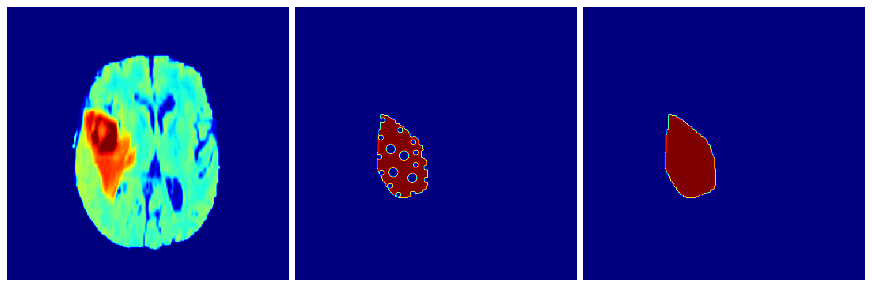

In [7]:
# visualise data before attempting to filter
imshow_multi([image_np, mask_np, original_seg])

# it can be seen in figure below that the segmentation mask has a lot of missing segmentations as compared to original mask
# original mask is only shown here as a reference, it is not used in any computation below


In [8]:
# apply GSF filtering to our data
# For more info on the hyperparameters mentioned here, please have a look
# at the Geos paper - especially the details of GSF filtering:

# Criminisi, Antonio, Toby Sharp, and Andrew Blake.
# "Geos: Geodesic image segmentation." ECCV, 2008.

# define whether we want to use geodesic distances for GSF
# lamda: 1.0 geodesic (recommended)
# lamda: 0.0 euclidean
# lamda: 0.5 mixture of geodesic/euclidean (may also work well)

lamda = 1.0

# v is a hyper parameter that establishes relationship between unary and spatial distances
v = 1000

# theta corresponds to the size of dilation/erosion operation
# it could be understood as maximum size of artefacts that need to be removed (in image/volume dimensions)
# setting theta=0 has no smoothing/artefact removal
#         theta > 0 will start smoothing/artefact removal
theta = 0  # no smoothing

print("\nimage resolution: {}".format(image_np.shape))
# on cuda
print("\non cuda:")
filtered_mask = np.squeeze(
    fastgeodis_GSF2d(image_torch, mask_torch, theta=theta, v=v, lamda=lamda).cpu().numpy()
)
filtered_mask = (filtered_mask > 0).astype(np.float32)
imshow_multi([image_np, filtered_mask])

# on cpu
print("\non cpu:")
filtered_mask_cpu = np.squeeze(
    fastgeodis_GSF2d(image_torch.to("cpu"), mask_torch.to("cpu"), theta=theta, v=v, lamda=lamda)
    .cpu()
    .numpy()
)
filtered_mask_cpu = (filtered_mask_cpu > 0).astype(np.float32)



image resolution: (1252, 1292)

on cuda:


TypeError: fastgeodis_GSF2d() missing 1 required positional argument: 'iter'


image resolution: (1252, 1292)

on cuda:
func:'GSF2d' took: 0.1108 sec

on cpu:
func:'GSF2d' took: 0.4945 sec


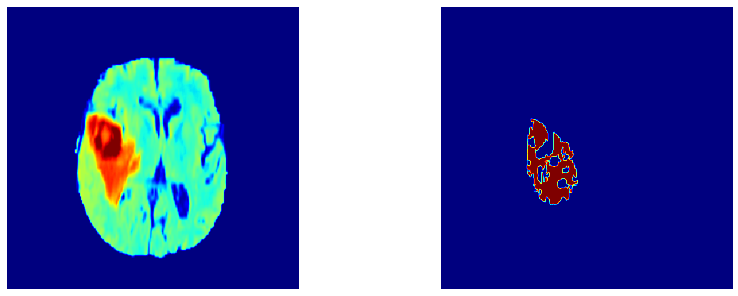

In [ ]:
theta = 4  # very small amount of smoothing

print("\nimage resolution: {}".format(image_np.shape))
# on cuda
print("\non cuda:")
filtered_mask = np.squeeze(
    fastgeodis_GSF2d(image_torch, mask_torch, theta=theta, v=v, lamda=lamda).cpu().numpy()
)
filtered_mask = (filtered_mask > 0).astype(np.float32)

imshow_multi([image_np, filtered_mask])

# on cpu
print("\non cpu:")
filtered_mask_cpu = np.squeeze(
    fastgeodis_GSF2d(image_torch.to("cpu"), mask_torch.to("cpu"), theta=theta, v=v, lamda=lamda)
    .cpu()
    .numpy()
)
filtered_mask_cpu = (filtered_mask_cpu > 0).astype(np.float32)



image resolution: (1252, 1292)

on cuda:
func:'GSF2d' took: 0.1124 sec

on cpu:
func:'GSF2d' took: 0.4980 sec


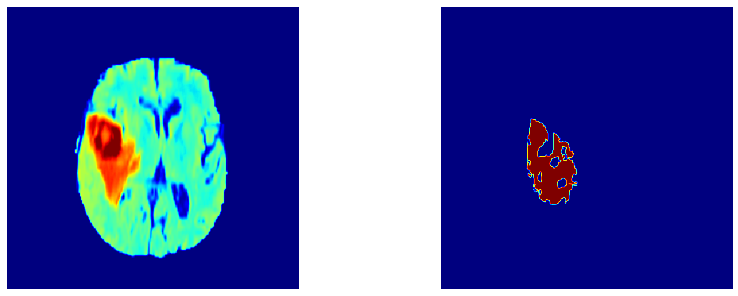

In [ ]:
theta = 8  # large amount of smoothing

print("\nimage resolution: {}".format(image_np.shape))
# on cuda
print("\non cuda:")
filtered_mask = np.squeeze(
    fastgeodis_GSF2d(image_torch, mask_torch, theta=theta, v=v, lamda=lamda).cpu().numpy()
)
filtered_mask = (filtered_mask > 0).astype(np.float32)

imshow_multi([image_np, filtered_mask])

# on cpu
print("\non cpu:")
filtered_mask_cpu = np.squeeze(
    fastgeodis_GSF2d(image_torch.to("cpu"), mask_torch.to("cpu"), theta=theta, v=v, lamda=lamda)
    .cpu()
    .numpy()
)
filtered_mask_cpu = (filtered_mask_cpu > 0).astype(np.float32)



image resolution: (1252, 1292)

on cuda:
func:'GSF2d' took: 0.1068 sec

on cpu:
func:'GSF2d' took: 0.5476 sec


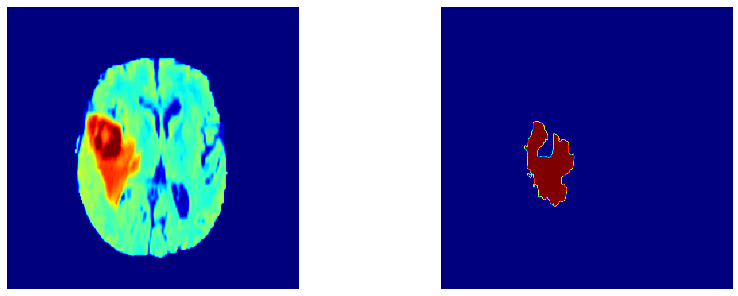

In [ ]:
theta = 25  # even bigger amount of smoothing

print("\nimage resolution: {}".format(image_np.shape))
# on cuda
print("\non cuda:")
filtered_mask = np.squeeze(
    fastgeodis_GSF2d(image_torch, mask_torch, theta=theta, v=v, lamda=lamda).cpu().numpy()
)
filtered_mask = (filtered_mask > 0).astype(np.float32)

imshow_multi([image_np, filtered_mask])

# on cpu
print("\non cpu:")
filtered_mask_cpu = np.squeeze(
    fastgeodis_GSF2d(image_torch.to("cpu"), mask_torch.to("cpu"), theta=theta, v=v, lamda=lamda)
    .cpu()
    .numpy()
)
filtered_mask_cpu = (filtered_mask_cpu > 0).astype(np.float32)


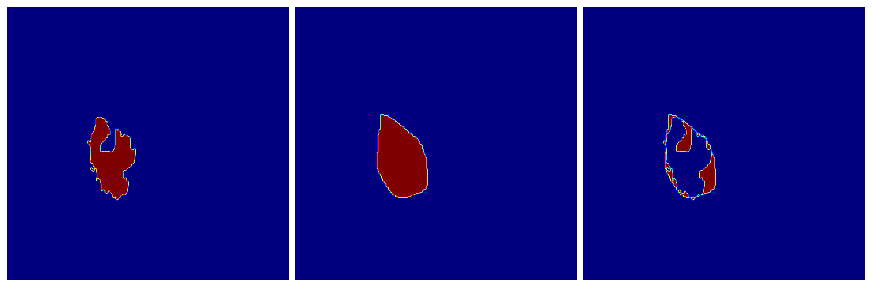

In [ ]:
# now we can compare the last result with original segmentation
imshow_multi([filtered_mask, original_seg, abs(original_seg - filtered_mask)])

# Comparison of Geodesic Symmetric C++ Implementation vs Python Implementation

In [ ]:
# define Geodesic Symmetric Filtering function in python using FastGeodis
def getDs(_I, _M, v, lamda):
    D_M = FastGeodis.generalised_geodesic2d(_I, _M, v=v, lamb=lamda, iter=2)
    D_Mb = FastGeodis.generalised_geodesic2d(_I, 1 - _M, v=v, lamb=lamda, iter=2)
    Ds_M = D_M - D_Mb
    return Ds_M


@timing
def GSF2d(_I, _M, theta=10, v=1000, lamda=1.0):
    Ds_M = getDs(_I, _M, v=v, lamda=lamda)

    Md = (Ds_M > theta).type(Ds_M.dtype)
    Me = (Ds_M > -theta).type(Ds_M.dtype)

    # imshow_multi([np.squeeze(Md.cpu().numpy()), np.squeeze(Me.cpu().numpy())])

    Dd_Md = -getDs(_I, 1 - Md, v=v, lamda=lamda)
    De_Me = getDs(_I, Me, v=v, lamda=lamda)
    return Dd_Md + De_Me


image resolution: (1252, 1292)

on cuda:
func:'GSF2d' took: 0.1258 sec
func:'fastgeodis_GSF2d' took: 0.1127 sec
SUCCESS: both outputs match


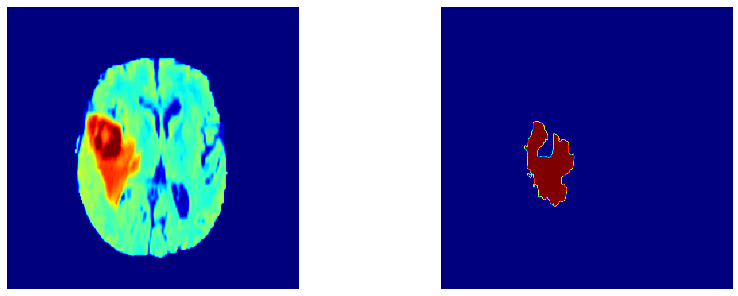

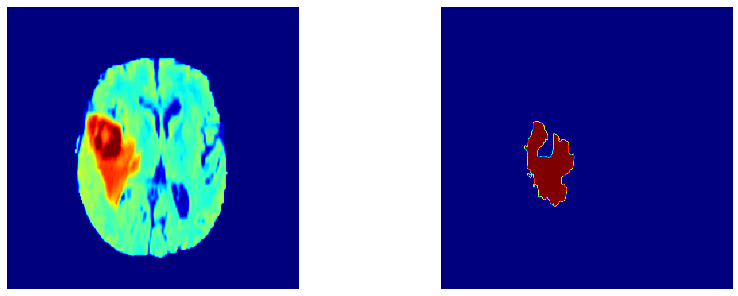

In [ ]:
# Comparing GSF2d C++ vs GSF2d Python

print("\nimage resolution: {}".format(image_np.shape))
# on cuda
print("\non cuda:")
filtered_mask_ = np.squeeze(
    GSF2d(image_torch, mask_torch, theta=theta, v=v, lamda=lamda).cpu().numpy()
)
filtered_mask = (filtered_mask_ > 0).astype(np.float32)
imshow_multi([image_np, filtered_mask])

# comparing GSF2d C++ vs GSF2d python
filtered_mask2_ = np.squeeze(
    fastgeodis_GSF2d(image_torch, mask_torch, theta=theta, v=v, lamda=lamda, iter=2)
    .cpu()
    .numpy()
)
filtered_mask2 = (filtered_mask2_ > 0).astype(np.float32)
imshow_multi([image_np, filtered_mask2])

if np.allclose(filtered_mask_, filtered_mask2_):
    print("SUCCESS: both outputs match")
else:
    print("FAILED: both outputs do not match")
